In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy

In [4]:
left = Image.open("sf_left.jpg")
right = Image.open("sf_right.jpg")
with open("sf_left_sf_right.json") as f:
    matches = json.load(f)
    points_left = np.array(matches["im1Points"])[:,::-1]
    points_right = np.array(matches["im2Points"])[:,::-1]


In [5]:
def plot_correspondences(left: np.ndarray, right: np.ndarray, points_left: np.ndarray, points_right: np.ndarray):
    new_image = Image.new('RGB', (left.width + right.width, max(left.height, right.height)))
    new_image.paste(left, (0, 0))
    new_image.paste(right, (left.width, 0))

    # Plot the new image
    plt.imshow(new_image)
    
    # Plot the points
    for i in range(points_left.shape[0]):
        plt.plot([points_left[i, 1], points_right[i, 1] + left.width], [points_left[i, 0], points_right[i, 0]], 'r-')
        plt.plot(points_left[i, 1], points_left[i, 0], 'bo')
        plt.plot(points_right[i, 1] + left.width, points_right[i, 0], 'bo')
    
    plt.axis('off')

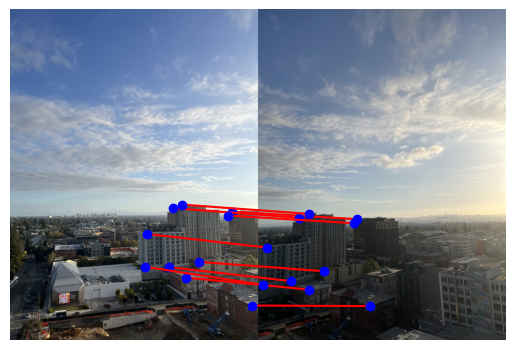

In [6]:
def plot_sf_correspondences():
    left = Image.open("sf_left.jpg")
    right = Image.open("sf_right.jpg")
    with open("sf_left_sf_right.json") as f:
        matches = json.load(f)
        points_left = np.array(matches["im1Points"])[:,::-1]
        points_right = np.array(matches["im2Points"])[:,::-1]
    plot_correspondences((left), (right), points_left, points_right)
    plt.savefig("sf_correspondences.jpg", bbox_inches='tight')
plot_sf_correspondences()

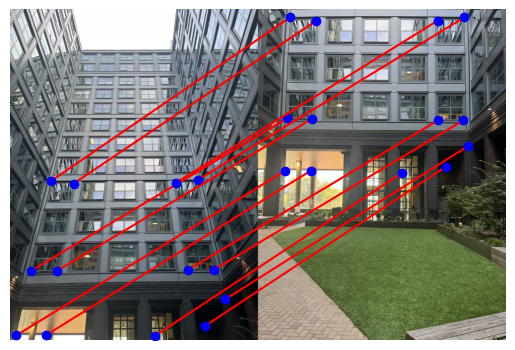

In [7]:
def plot_anchor_correspondences():
    left = Image.open("anchor_top.jpg")
    right = Image.open("anchor_bot.jpg")
    with open("anchor_top_anchor_bot.json") as f:
        matches = json.load(f)
        points_left = np.array(matches["im1Points"])[:,::-1]
        points_right = np.array(matches["im2Points"])[:,::-1]
    plot_correspondences((left), (right), points_left, points_right)
    plt.savefig("anchor_correspondences.jpg", bbox_inches='tight')
plot_anchor_correspondences()

In [8]:
def computeA_slice(im1_pt, im2_pt):
    # this is for mapping im2 onto im1
    x, y = im2_pt
    u, v = im1_pt
    return np.array([
        [x, y, 1, 0, 0, 0, -u*x, -u*y],
        [0, 0, 0, x, y, 1, -v*x, -v*y]
    ])

def computeH(im1_pts, im2_pts, verbose=False):
    # compute the homography H that maps points from image 2 to image 1
    slices = []
    for i in range(im1_pts.shape[0]):
        A_slice = computeA_slice(im1_pts[i], im2_pts[i])
        slices.append(A_slice)
    A = np.concatenate(slices)
    if verbose:
        print("A shape:", A.shape)
        print("A:", A)
    
    b = im1_pts.flatten()
    if verbose:
        print("b shape:", b.shape)
        print("b:", b)

    H = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.concatenate((H, [1])).reshape(3, 3)

    return H

In [9]:
np.set_printoptions(linewidth=200)
print(computeH(points_left, points_right, verbose=True))

A shape: (20, 8)
A: [[     2558      1205         1         0         0         0  -6308028  -2971530]
 [        0         0         0      2558      1205         1  -6916832  -3258320]
 [     2541       497         1         0         0         0  -6156843  -1204231]
 [        0         0         0      2541       497         1  -5033721   -984557]
 [     2494       625         1         0         0         0  -5938214  -1488125]
 [        0         0         0      2494       625         1  -5234906  -1311875]
 [     3314       404         1         0         0         0 -10412588  -1269368]
 [        0         0         0      3314       404         1  -6415904   -782144]
 [     3417       622         1         0         0         0 -11173590  -2033940]
 [        0         0         0      3417       622         1  -7319214  -1332324]
 [     3618      1369         1         0         0         0 -13064598  -4943459]
 [        0         0         0      3618      1369         1 -1065

In [10]:
def warpImageBilinear(im, H):
    H_inv = np.linalg.inv(H)
    h, w, _ = im.shape
    
    # apply H to the corners of the image
    corners = np.array([[0, 0, 1], [h, 0, 1], [0, w, 1], [h, w, 1]])
    proj_corners = H @ corners.T
    # upper left min x, min y
    proj_corners /= proj_corners[2]
    min_y, min_x, _ = np.floor(np.min(proj_corners, axis=1)).astype(int)
    max_y, max_x, _ = np.ceil(np.max(proj_corners, axis=1)).astype(int)
    
    # generate mesh grid
    yxz = np.array(np.meshgrid(np.arange(int(min_y), int(max_y)), np.arange(int(min_x), int(max_x)), [1], indexing='ij'))
    base_points = np.einsum("p y x z, i p -> i y x", yxz, H_inv)
    base_points /= base_points[2]
    
    # instead of r_int we just take the floor since we're back to grid
    base_image = np.zeros((max_y - min_y, max_x - min_x, 3))
    interp_mask = np.zeros((max_y - min_y, max_x - min_x))
    for i in np.array([[0,0], [0,1], [1, 0], [1, 1]]):
        nn_points = np.floor(base_points).astype(int)
        
        movement = base_points - nn_points
        
        # remove z axis
        nn_points = nn_points[:2] # shape [2, h, w]
        
        # generate shift
        nn_points += i.reshape((-1, 1, 1))
        
        mask = np.all(nn_points >= 0, axis=0)
        mask &= nn_points[0] < h
        mask &= nn_points[1] < w
        
        # mask into 0 index
        nn_points[~np.stack((mask, mask))] = 0
    
        # cast all points!
        sy, sx = i
        interp_y = (1 - movement[0]) if sy == 0 else movement[0]
        interp_x = (1 - movement[1]) if sx == 0 else movement[1]
        quarter_mask = interp_y * interp_x * mask
        base_image += im[*nn_points] * quarter_mask[:, :, None]
        interp_mask += quarter_mask

    return base_image, interp_mask, np.array([int(min_y), int(min_x)])

In [11]:
def warpImageNearestNeighbor(im, H):
    H_inv = np.linalg.inv(H)
    h, w, _ = im.shape
    # find the coords of the transform.
    # H @ 0, 0 will give the coords of the top left of the photo relative to the base image
    # If we want to retrieve an array with the image we can paste into the base image we need to find the x, y offset
    # of the top left which might not be 0, 0
    # min x and min y of the corners will give us the offset of the full image including black space and enough to fit the image
    
    # apply H to the corners of the image
    corners = np.array([[0, 0, 1], [h, 0, 1], [0, w, 1], [h, w, 1]])
    proj_corners = np.einsum("o i, n i -> n o", H, corners)
    proj_corners /= proj_corners[:, 2:3]
    proj_corners = proj_corners.T
    print(proj_corners.T.astype(int))
    # upper left min x, min y
    min_y, min_x, _ = np.floor(np.min(proj_corners, axis=1)).astype(int)
    max_y, max_x, _ = np.ceil(np.max(proj_corners, axis=1)).astype(int)
    print(min_y, min_x, max_y, max_x)
    
    # generate mesh grid
    yxz = np.array(np.meshgrid(np.arange(int(min_y), int(max_y)), np.arange(int(min_x), int(max_x)), [1], indexing='ij'))
    base_points = np.einsum("p y x z, i p -> i y x", yxz, H_inv)
    # output_shape = (int(max_y)-int(min_y), int(max_x)-int(min_x), 1)
    # y = np.broadcast_to(np.arange(int(min_y), int(max_y)).reshape(-1, 1, 1), output_shape)
    # x = np.broadcast_to(np.arange(int(min_x), int(max_x)).reshape(1, -1, 1), output_shape)
    # z = np.ones((int(max_y)-int(min_y), int(max_x)-int(min_x), 1))
    # yxz = np.dstack((y, x, z))
    # base_points = np.einsum("y x p, i p -> i y x", yxz, H_inv)
    base_points /= base_points[2]
    nn_points = np.rint(base_points[:2]).astype(int)
    
    # remove z axis
    mask = np.all(nn_points >= 0, axis=0)
    mask &= nn_points[0] < h
    mask &= nn_points[1] < w
    
    # zero index the mask to prevent out of bounds
    nn_points[~np.stack((mask, mask))] = 0
    
    # cast all points!
    return im[*nn_points] * mask[:,:,None], mask, np.array([int(min_y), int(min_x)])

In [12]:
def rectify(im, new_points, orig_points, warper = warpImageNearestNeighbor):
    # crop im
    max_y, max_x = np.max(orig_points, axis=0)
    min_y, min_x = np.min(orig_points, axis=0)
    im = im[min_y:max_y,min_x:max_x]
    
    # orig points need to be relative to cropped image
    orig_points = orig_points - np.array([min_y, min_x]).reshape((1, 2))
    h = computeH(new_points, orig_points)
    
    plt.imshow(im)
    plt.figure()
    warped_im, mask, offset = warper(im, h)
    
    # project the new points to crop again
    corners = np.array(np.pad(orig_points, ((0, 0), (0, 1)), constant_values=1)) # shape [n, 3]
    plt.plot(corners[:, 1], corners[:, 0], 'bo')
    print(corners.astype(int))
    proj_corners = np.einsum("o i, n i -> n o", h, corners)
    proj_corners /= proj_corners[:, 2:3]
    reverse_points = np.einsum("o i, n i -> n o", np.linalg.inv(h), corners)
    proj_corners = proj_corners[:, :2]
    print(proj_corners.astype(int))
    offset_corners = proj_corners - offset.reshape((1, 2))
    print(offset_corners.astype(int))
    max_y, max_x = np.max(proj_corners, axis=0)
    min_y, min_x = np.min(proj_corners, axis=0)
    for i in range(4):
        plt.plot(proj_corners[i, 1] , proj_corners[i, 0], 'ro')
        
    reverse_points /= reverse_points[:, 2:3]
    reverse_points = reverse_points[:, :2]
    plt.plot(corners[:, 1], corners[:, 0], 'yo')
    
    plt.gca().invert_yaxis()
    plt.figure()
    return warped_im

[[   2   -6    1]
 [1022    0    1]
 [-566 1371    1]
 [ 999 1000    1]]
-566.932515121027 -6.715022501029756 1022.8537462480821 1371.5606228143145
[[   0    7    1]
 [1815    0    1]
 [ 463  805    1]
 [1867  943    1]]
[[   0    0]
 [ 999    0]
 [   0  999]
 [ 999 1000]]
[[ 566    6]
 [1565    6]
 [ 565 1005]
 [1565 1006]]


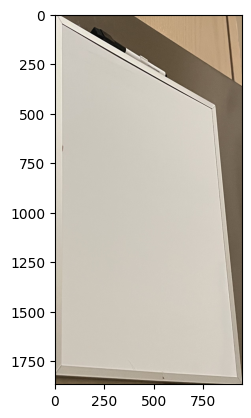

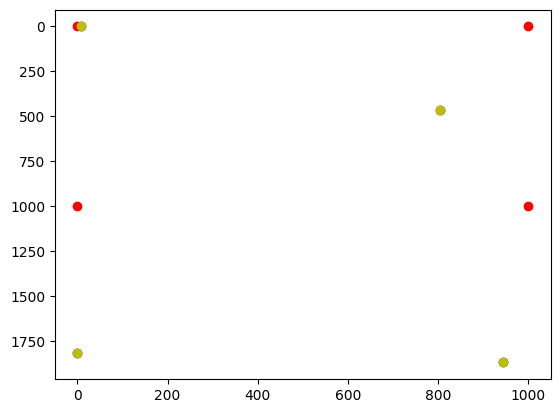

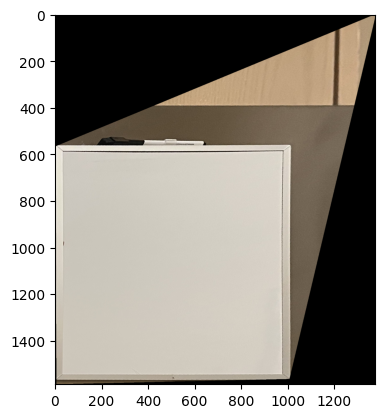

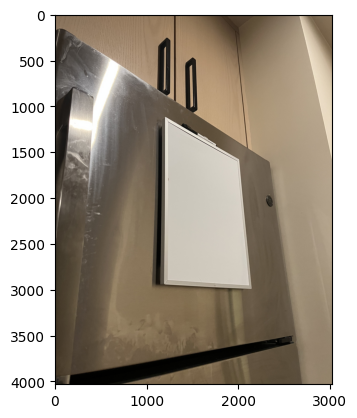

[[   0    7    1]
 [1815    0    1]
 [ 463  805    1]
 [1867  943    1]]
[[   0    0]
 [ 999    0]
 [   0  999]
 [ 999 1000]]
[[ 567    7]
 [1566    7]
 [ 566 1006]
 [1566 1007]]


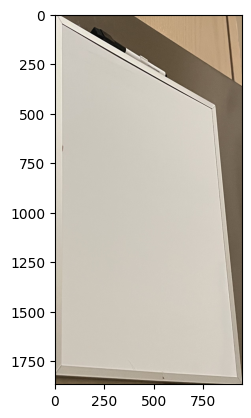

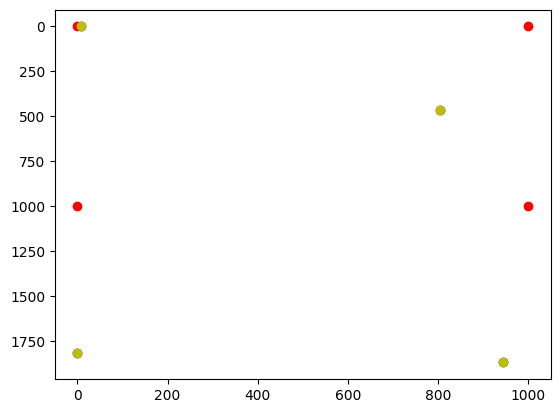

<Figure size 640x480 with 0 Axes>

In [13]:
def rectify_whiteboard():
    orig_points = ["1201,1125","1194,2940","1999,1588","2137,2992"]
    orig_points = [point.split(",") for point in orig_points]
    orig_points = np.array(orig_points).astype(int)
    orig_points = orig_points[:, ::-1]
    
    # new_points = np.array([[0, 0], [1100, 0], [0, 850], [1100, 850]]) * 2
    new_points = np.array([[0, 0], [1000, 0], [0, 1000], [1000, 1000]])
    im = np.array(Image.open("whiteboard.jpg")) / 255
    im_new = rectify(im, new_points, orig_points)
    plt.imshow(im_new)
    plt.show()
    plt.imshow(im)
    plt.show()
    plt.imsave("rectified_whiteboard.jpg", im_new)
    
    im_new = rectify(im, new_points, orig_points, warper=warpImageBilinear)
    plt.imsave("rectified_whiteboard_bilinear.jpg", im_new)
rectify_whiteboard()

[[-37 -61   1]
 [440   0   1]
 [  7 817   1]
 [481 666   1]]
-37.889626044629196 -61.11050037861378 481.532174601601 817.9069015997623
[[  63  176    1]
 [1112    0    1]
 [   0 2227    1]
 [ 987 2633    1]]
[[  0   0]
 [440   0]
 [  0 679]
 [439 680]]
[[ 36  61]
 [477  61]
 [ 37 740]
 [476 741]]


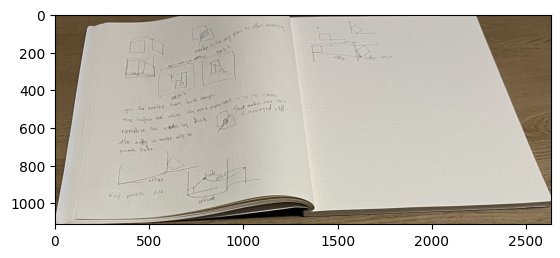

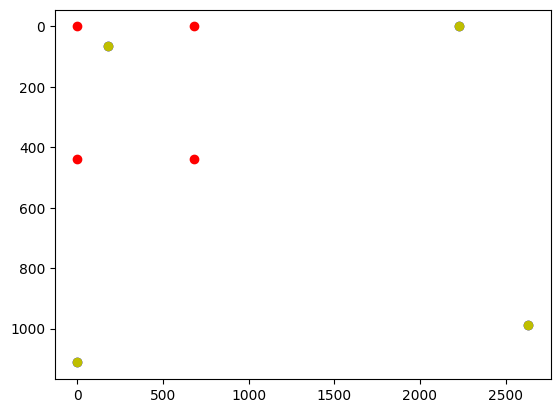

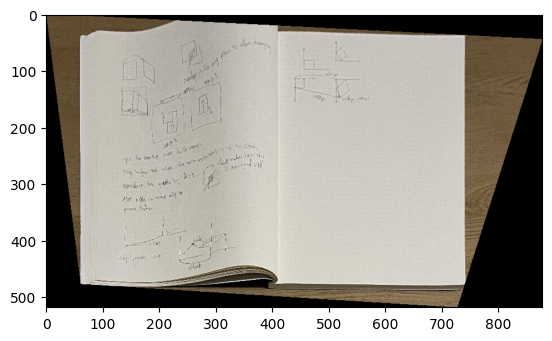

[[  63  176    1]
 [1112    0    1]
 [   0 2227    1]
 [ 987 2633    1]]
[[  0   0]
 [440   0]
 [  0 679]
 [439 680]]
[[ 37  62]
 [478  62]
 [ 38 741]
 [477 742]]


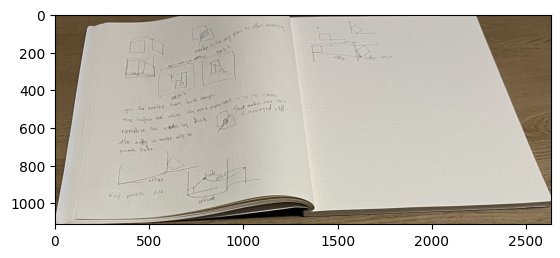

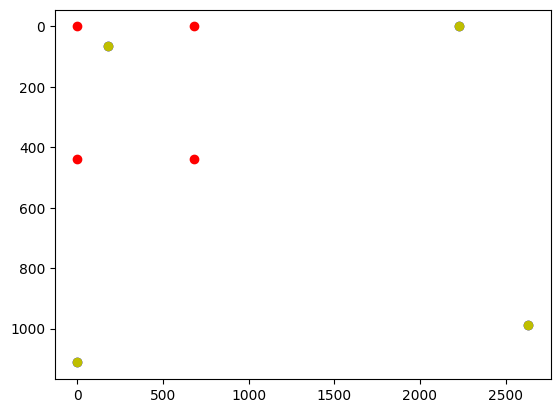

<Figure size 640x480 with 0 Axes>

In [14]:
def rectify_notebook():
    orig_points = ["403,365","227,1414","2454,302","2860,1289"]
    orig_points = [point.split(",") for point in orig_points]
    orig_points = np.array(orig_points).astype(int)
    
    # xy to yx
    orig_points = orig_points[:, ::-1]
    
    # 17:11 aspect ratio
    # points are order (0, 0), (1, 0), (0, 1), (1, 1)
    new_points = np.array([[0, 0], [110, 0], [0, 170], [110, 170]]) * 4
    im = np.array(Image.open("notebook.jpg")) / 255
    im_new = rectify(im, new_points, orig_points)
    plt.imshow(im_new)
    plt.show()
    
    plt.imsave("rectified_notebook.jpg", im_new)
    
    im_new = rectify(im, new_points, orig_points, warper=warpImageBilinear)
    plt.imsave("rectified_notebook_bilinear.jpg", im_new)
rectify_notebook()

In [2]:
def rectify_shower():
    # orig_points = ["683,2437","1163,2913","1904,1691","2355,1963"]
    orig_points = ["1119,1481","1091,2744","1891,1428","1823,3040"]
    orig_points = [point.split(",") for point in orig_points]
    orig_points = np.array(orig_points).astype(int)
    
    # xy to yx
    orig_points = orig_points[:, ::-1]
    
    # 2.8:1 aspect ratio
    # points are order (0, 0), (1, 0), (0, 1), (1, 1)
    new_points = np.array([[0, 0], [200, 0], [0, 100], [200, 100]])
    im = np.array(Image.open("shower.jpg")) / 255
    im_new = rectify(im, new_points, orig_points)
    plt.imshow(im_new)
    plt.show()
rectify_shower()

NameError: name 'np' is not defined

[[-1440  1034     1]
 [  601  -432     1]
 [  564  3491     1]
 [ 2048  1137     1]]
-1440.046210854769 -432.37835715009015 2048.0617862766676 3491.4226926873157
[[ 773    0    1]
 [1244  475    1]
 [   0 1220    1]
 [ 271 1664    1]]
[[   0    0]
 [ 999    0]
 [   0 2799]
 [ 999 2799]]
[[1440  432]
 [2439  431]
 [1439 3231]
 [2439 3231]]


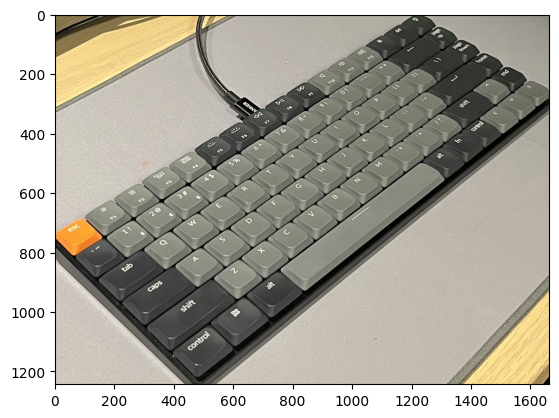

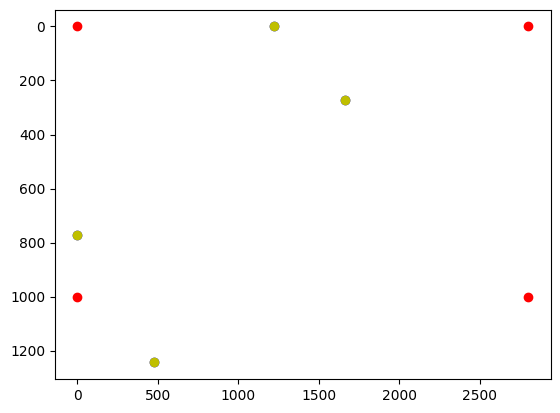

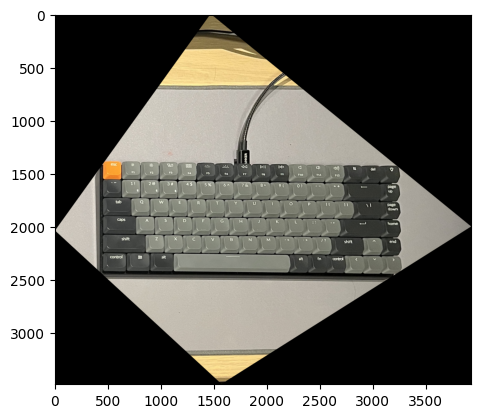

[[ 773    0    1]
 [1244  475    1]
 [   0 1220    1]
 [ 271 1664    1]]
[[   0    0]
 [ 999    0]
 [   0 2799]
 [ 999 2799]]
[[1441  433]
 [2440  432]
 [1440 3232]
 [2440 3232]]


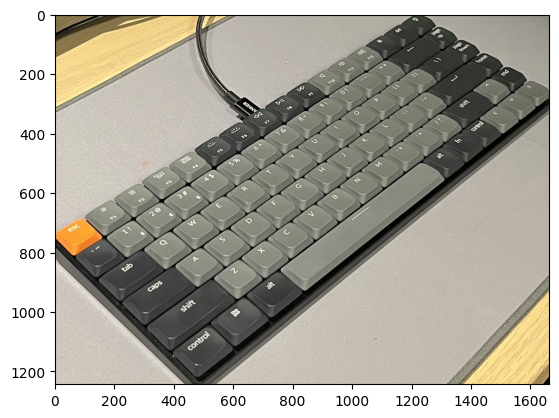

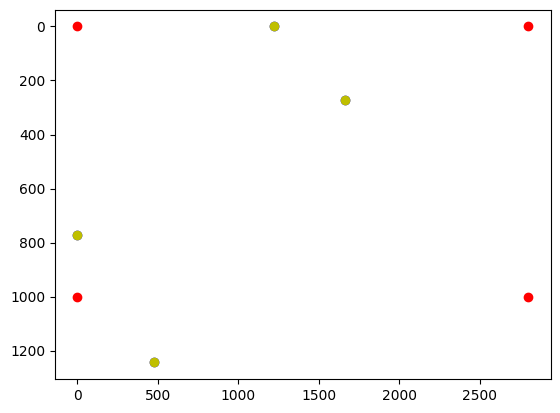

<Figure size 640x480 with 0 Axes>

In [581]:
def rectify_keeb():
    # orig_points = ["683,2437","1163,2913","1904,1691","2355,1963"]
    orig_points = ["685,2465","1160,2936","1905,1692","2349,1963"]
    orig_points = [point.split(",") for point in orig_points]
    orig_points = np.array(orig_points).astype(int)
    
    # xy to yx
    orig_points = orig_points[:, ::-1]
    
    # 2.8:1 aspect ratio
    # points are order (0, 0), (1, 0), (0, 1), (1, 1)
    new_points = np.array([[0, 0], [100, 0], [0, 280], [100, 280]]) * 10
    im = np.array(Image.open("rectify_keeb.jpg")) / 255
    im_new = rectify(im, new_points, orig_points)
    plt.imshow(im_new)
    plt.show()
    plt.imsave("rectified_keeb.jpg", im_new)
    
    im_new = rectify(im, new_points, orig_points, warper=warpImageBilinear)
    plt.imsave("rectified_keeb_bilinear.jpg", im_new)
rectify_keeb()

In [ ]:
def mosaic(im1, im2, points_left, points_right, merge=True, save_mask=False):
    H = computeH(points_left, points_right)
    im2_w, mask, warp_offset = warpImageNearestNeighbor(im2, H)
    h1, w1, _ = im1.shape
    h2, w2, _ = im2_w.shape
    min_y = min(0, warp_offset[0])
    min_x = min(0, warp_offset[1])
    
    # offset from im1 to canvas 00 and im2 to canvas 00
    offset1 = - np.array([min_y, min_x])
    offset2 = offset1 + warp_offset
    
    max_y = max(h1, warp_offset[0] + h2)
    max_x = max(w1, warp_offset[1] + w2)
    canvas = np.zeros((max_y - min_y, max_x - min_x, 3))
    if merge:
        canvas_mask1 = np.ones((max_y - min_y, max_x - min_x), dtype=bool)
        canvas_mask2 = np.ones((max_y - min_y, max_x - min_x), dtype=bool)
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.figure()
        
        canvas_mask1[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2] *= (1 - mask).astype(bool)
        canvas_mask2[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] *= False
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.figure()
        
        negative_mask = ~canvas_mask1 & ~canvas_mask2
        canvas_mask1[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] |= True
        canvas_mask2[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2] |= mask.astype(bool)
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.savefig("base_mask.jpg", bbox_inches='tight')
            plt.figure()
            


        # find dist to bg which is the opposite photo
        mask1 = scipy.ndimage.distance_transform_edt(canvas_mask1)
        if save_mask:
            plt.imshow(mask1)
            plt.savefig("bw_dist.jpg", bbox_inches='tight')
            plt.figure()
        mask2 = scipy.ndimage.distance_transform_edt(canvas_mask2)

        if save_mask:
            plt.imshow(negative_mask)
            plt.savefig("negative_mask.jpg", bbox_inches='tight')
            plt.figure()
            

        # apply normalization to get weighted average by distance
        canvas_mask1 = canvas_mask1 * ~negative_mask + negative_mask * mask1 / (mask1 + mask2)
        
        if save_mask:
            plt.imshow(canvas_mask1)
            plt.savefig("full_mask.jpg", bbox_inches='tight')
            plt.figure()
        
        
        canvas_mask2 = canvas_mask2 * ~negative_mask + negative_mask * (1 - canvas_mask1)
        if save_mask:
            plt.imshow(canvas_mask2)
            plt.figure()

        canvas[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] = im1 * canvas_mask1[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1][:, :, None]
        canvas[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2] += im2_w * canvas_mask2[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2][:, :, None]
    else:
        canvas[offset1[0]:offset1[0] + h1, offset1[1]:offset1[1] + w1] = im1
        canvas[offset2[0]:offset2[0] + h2, offset2[1]:offset2[1] + w2][mask[:, :]] = im2_w[mask[:, :]]
    return canvas

In [15]:
checker_block = np.array([[0, 1],
                          [1, 0]])

# Tile the block to create a larger checkerboard (e.g., 8x8)
# The (4, 4) argument means repeating the block 4 times in both dimensions
checkerboard = np.tile(checker_block, (8, 8))
checkerboard = np.dstack([checkerboard] * 3).astype(float)
response1 = warpImageNearestNeighbor(checkerboard, np.array([[1, 0, 0], [0.1, 1, 0], [0, 0, 1]]))
response2 = warpImageBilinear(checkerboard, np.array([[1, 0, 0], [0.1, 1, 0], [0, 0, 1]]))

[[ 0  0  1]
 [16  1  1]
 [ 0 16  1]
 [16 17  1]]
0.0 0.0 16.0 17.6


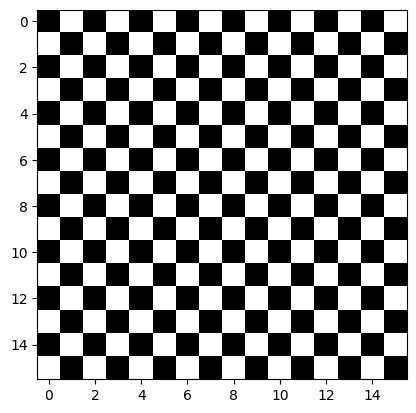

In [16]:
plt.imshow(checkerboard)
plt.imsave("checkerboard.jpg", checkerboard)

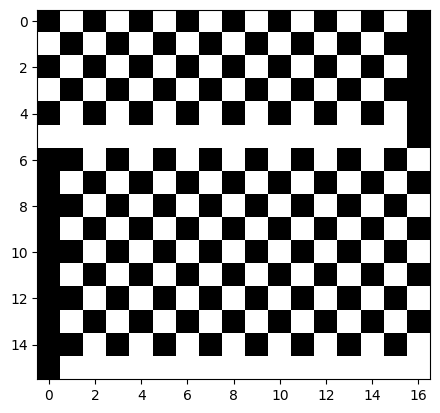

In [22]:
plt.imshow(response1[0])
plt.imsave("checkerboard_nn.jpg", response1[0])

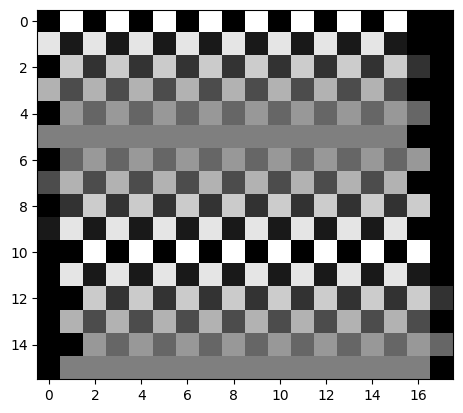

In [23]:
plt.imshow(response2[0])
plt.imsave("checkerboard_bilinear.jpg", response2[0])

In [ ]:
result = mosaic(np.array(left) / 255, np.array(right) / 255, points_left, points_right)

In [ ]:
plt.imshow(result)

In [ ]:
image = Image.fromarray((result * 255).astype(np.uint8))
save_path = "mosaic_output.jpg"
image.save(save_path)

[[  100  1427     1]
 [ 3717  1632     1]
 [-1397  5539     1]
 [ 4723  5649     1]]
-1398 1427 4724 5650
[[  100  1427     1]
 [ 3717  1632     1]
 [-1397  5539     1]
 [ 4723  5649     1]]
-1398 1427 4724 5650


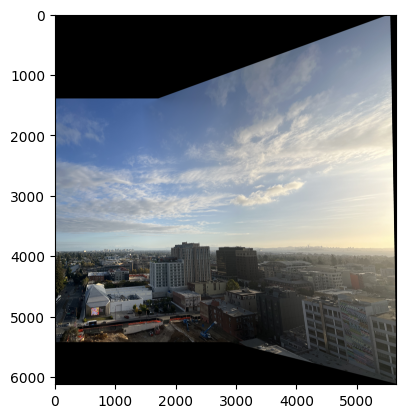

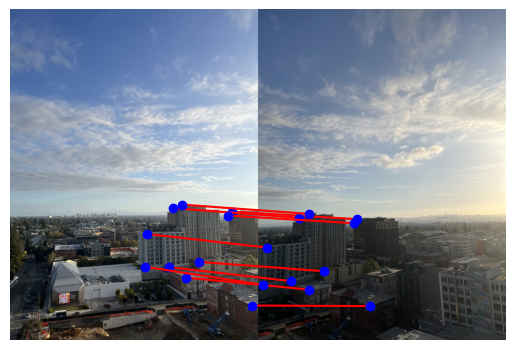

In [17]:
def sf_mosaic():
    left = Image.open("sf_left.jpg")
    right = Image.open("sf_right.jpg")
    with open("sf_left_sf_right.json") as f:
        matches = json.load(f)
        points_left = np.array(matches["im1Points"])[:,::-1]
        points_right = np.array(matches["im2Points"])[:,::-1]
    
    result = mosaic(np.array(left) / 255, np.array(right) / 255, points_left, points_right, merge=False)
    plt.imshow(result)
    plt.imsave("sf_mosaic_unmerged.jpg", result)

    result = mosaic(np.array(left) / 255, np.array(right) / 255, points_left, points_right, merge=True)
    plt.imshow(result)
    plt.imsave("sf_mosaic.jpg", result)
    
    plt.figure()
    plot_correspondences((left), (right), points_left, points_right)
    plt.savefig("sf_correspondences.jpg", bbox_inches='tight')

sf_mosaic()

[[  346  1874     1]
 [ 3971  2084     1]
 [-1921  6886     1]
 [ 6074  7985     1]]
-1922 1874 6075 7986
[[  346  1874     1]
 [ 3971  2084     1]
 [-1921  6886     1]
 [ 6074  7985     1]]
-1922 1874 6075 7986


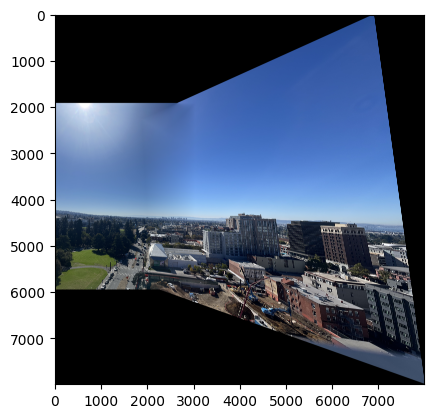

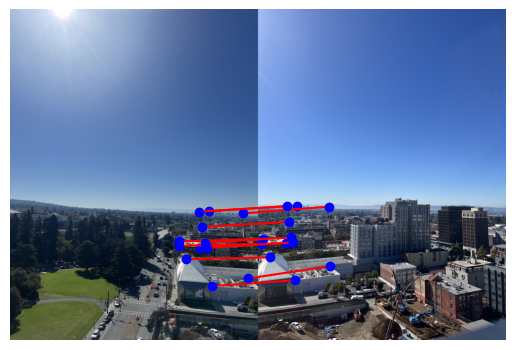

In [18]:
def oakland_mosaic():
    left = Image.open("oakland_right.jpg")
    right = Image.open("oakland_left.jpg")
    with open("oakland_right_oakland_left.json") as f:
        matches = json.load(f)
        points_left = np.array(matches["im1Points"])[:,::-1]
        points_right = np.array(matches["im2Points"])[:,::-1]
    
    result = mosaic(np.array(left) / 255, np.array(right) / 255, points_left, points_right, merge=False)
    plt.imshow(result)
    plt.imsave("oakland_mosaic_unmerged.jpg", result)

    result = mosaic(np.array(left) / 255, np.array(right) / 255, points_left, points_right, merge=True)
    plt.imshow(result)
    plt.imsave("oakland_mosaic.jpg", result)
    
    plt.figure()
    plot_correspondences((left), (right), points_left, points_right)
    plt.savefig("oakland_correspondences.jpg", bbox_inches='tight')

oakland_mosaic()

[[ 2030   184     1]
 [ 9322 -1742     1]
 [ 2007  2695     1]
 [ 8929  4663     1]]
2007 -1743 9323 4664
[[ 2030   184     1]
 [ 9322 -1742     1]
 [ 2007  2695     1]
 [ 8929  4663     1]]
2007 -1743 9323 4664


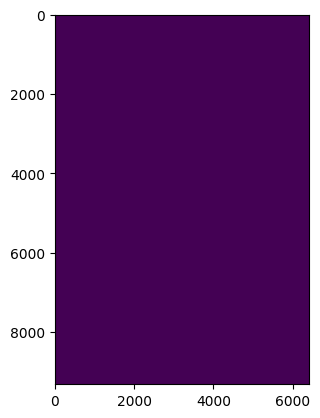

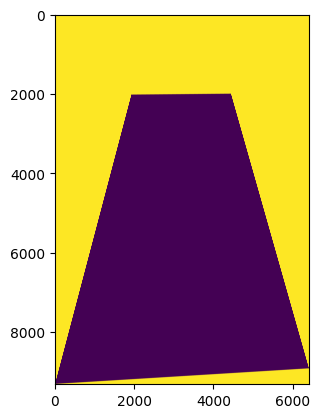

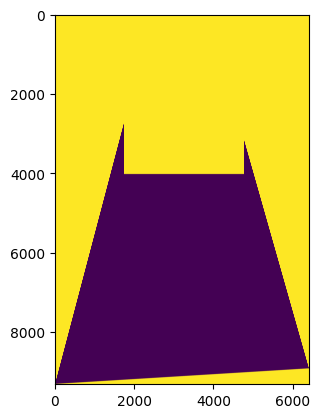

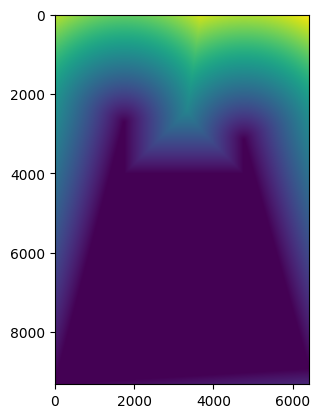

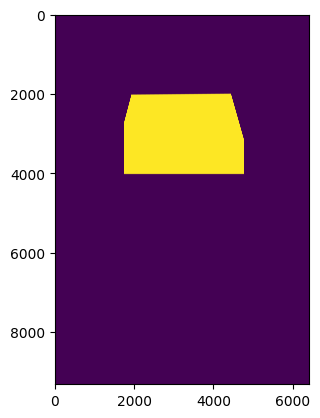

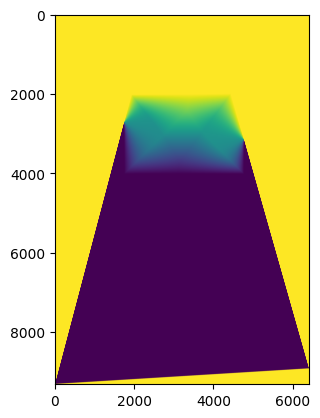

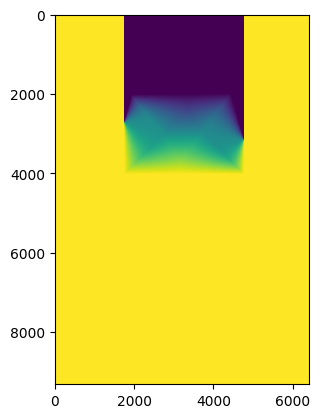

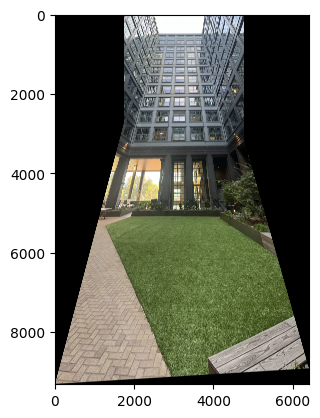

In [15]:
def anchor_mosaic():
    left = Image.open("anchor_top.jpg")
    right = Image.open("anchor_bot.jpg")
    with open("anchor_top_anchor_bot.json") as f:
        matches = json.load(f)
        points_left = np.array(matches["im1Points"])[:,::-1]
        points_right = np.array(matches["im2Points"])[:,::-1]
    
    result = mosaic(np.array(left) / 255, np.array(right) / 255, points_left, points_right, merge=False)
    plt.imshow(result)
    plt.imsave("anchor_mosaic_unmerged.jpg", result)
    
    result = mosaic(np.array(left) / 255, np.array(right) / 255, points_left, points_right, save_mask=True)
    plt.imshow(result)
    plt.imsave("anchor_mosaic.jpg", result)

anchor_mosaic()